# Лабораторная работа №4

## Суворов Роман ИВТ 2.1

Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [2]:
from PIL import Image

import matplotlib.pyplot as plt

import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [ ]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
# https://storage.yandexcloud.net/algorithmic-datasets/bus.zip
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

IMAGE_PATH = '/content/bus/'

os.listdir(IMAGE_PATH)

checkdir:  cannot create extraction directory: /content/bus
           No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: '/content/bus/'

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['05217.jpg', '00845.jpg', '00826.jpg', '04428.jpg', '05652.jpg', '02210.jpg', '05998.jpg', '06087.jpg', '01613.jpg', '02200.jpg', '01840.jpg', '05792.jpg', '02889.jpg', '03629.jpg', '06065.jpg', '01476.jpg', '03105.jpg', '03329.jpg', '00507.jpg', '04047.jpg', '01579.jpg', '04099.jpg', '03323.jpg', '03974.jpg', '04880.jpg', '04173.jpg', '01454.jpg', '02132.jpg', '00250.jpg', '01682.jpg', '03382.jpg', '01053.jpg', '02284.jpg', '00717.jpg', '02378.jpg', '01827.jpg', '00408.jpg', '05530.jpg', '03684.jpg', '03260.jpg', '02471.jpg', '00562.jpg', '00122.jpg', '04771.jpg', '02346.jpg', '04943.jpg', '06157.jpg', '01201.jpg', '04152.jpg', '04200.jpg', '03257.jpg', '02481.jpg', '05285.jpg', '05726.jpg', '01347.jpg', '00795.jpg', '03574.jpg', '05244.jpg', '05262.jpg', '02752.jpg', '03577.jpg', '02777.jpg', '04398.jpg', '04599.jpg', '03019.jpg', '06326.jpg', '00931.jpg', '03608.jpg', '04112.jpg', '00892.jpg', '02429.jpg', '01294.jpg', '03017.jpg', '02005.jpg', '04359.jpg', '04742.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

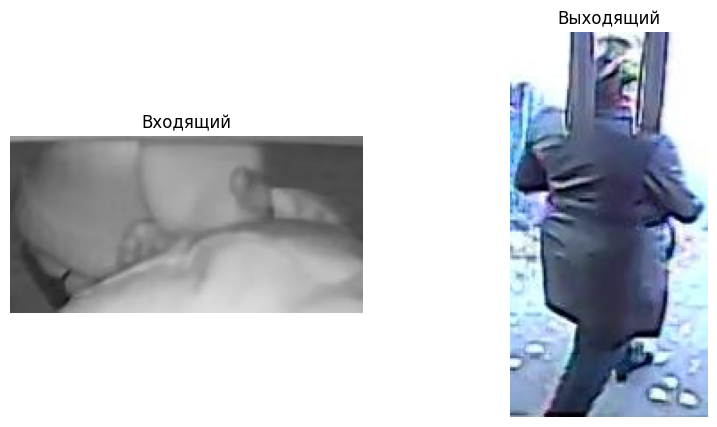

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


## Решение

### 1. Предобработка данных

In [ ]:
# Разделение данных на обучающую и тестовую выборки
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Загрузка и преобразование изображений
def load_images(image_paths, target_size=(150, 150)):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array /= 255.0  # Нормализация
        images.append(img_array)
    return np.array(images)

# Загрузка всех изображений
X = load_images(data_files, target_size=(150, 150))
y = to_categorical(data_labels)  # One-hot кодирование

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### 2. Создание модели CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Блок 1
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Блок 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Блок 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Полносвязные слои
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(CLASS_COUNT, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3. Обучение модели

In [ ]:
# Параметры обучения
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.6758 - loss: 0.8566 - val_accuracy: 0.6081 - val_loss: 0.6789
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8528 - loss: 0.3536 - val_accuracy: 0.8211 - val_loss: 0.3987
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9006 - loss: 0.2404 - val_accuracy: 0.8156 - val_loss: 0.6834
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9096 - loss: 0.2196 - val_accuracy: 0.8162 - val_loss: 1.0254
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9325 - loss: 0.1673 - val_accuracy: 0.7001 - val_loss: 0.6390
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9498 - loss: 0.1265 - val_accuracy: 0.8800 - val_loss: 0.2671
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9659 - loss: 0.1048 - val_accuracy: 0.9576 - val_loss: 0.1072
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9745 - loss: 0.0738 - va

### 4. Оценка результатов


Точность на тестовых данных: 99.45%


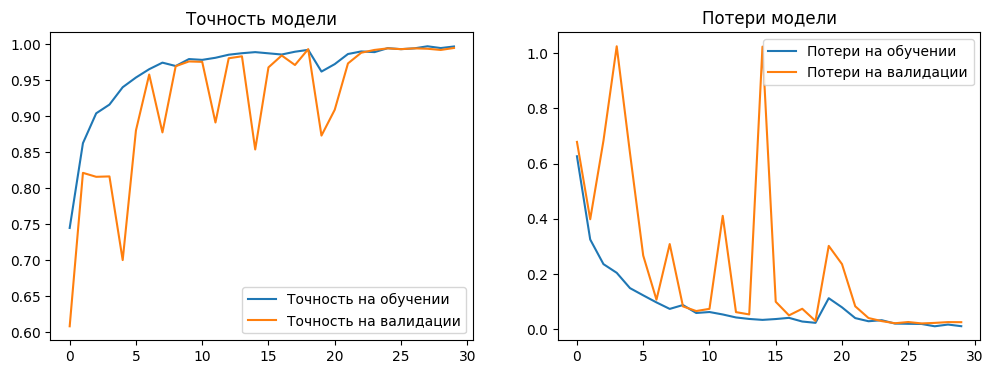

In [ ]:
# Оценка точности на тестовых данных
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'\nТочность на тестовых данных: {test_acc:.2%}')

# Визуализация процесса обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность модели')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('Потери модели')
plt.legend()
plt.show()